# **1. Introduction**

This notebook demonstrates our anomaly detection pipeline, which uses a k-NN graph of BERT-embedded text chunks and spectral analysis to highlight anomalies. We will:

- Download and preprocess a large text.
- Insert a few artificially crafted anomalies.
- Generate BERT embeddings for the text chunks.
- Build a k-NN graph with a chosen \(`k`\).
- Compute the node signal (combining global distance and local mismatch).
- Identify high-frequency nodes via the normalized Laplacian.
- Visualize the amplitudes and see if our inserted anomalies stand out.


In [15]:
#@title 1. Environment Setup

!pip install nltk transformers requests matplotlib networkx  # Ensure these are installed
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import numpy as np
import networkx as nx
import torch
import requests
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from bs4 import BeautifulSoup
import re


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")


[INFO] Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Global Parameters**

The following are the key parameters used throughout the anomaly detection pipeline:

1. **k (k-NN Graph)**:
   - `K` defines the number of nearest neighbors to consider when constructing the k-NN graph. This parameter impacts how closely connected nodes are in the graph.

2. **High-Frequency Component Detection**:
   - `HIGH_FREQ_METHOD = 'fraction'`: Specifies how we detect high-frequency eigenvalues. Options include:
     - `'fraction'`: Select eigenvalues above a fraction of the largest eigenvalue.
     - `'topk'`: Select the top `k` eigenvalues with the highest frequency.
   - `HIGH_FREQ_CUTOFF_FRACTION = 0.7`: If using the `'fraction'` method, only eigenvalues ≥ 70% of the largest eigenvalue are considered high-frequency.
   - `HIGH_FREQ_TOPK = 10`: If using the `'topk'` method, select the top 10 eigenvalues.

3. **Anomaly Detection Threshold**:
   - `ANOMALY_TOP_PCT = 10`: Nodes with amplitudes in the top 10% of high-frequency signals are flagged as potential anomalies.

4. **Chunking and Filtering**:
   - `CHUNK_SIZE = 5`: Text is divided into chunks, with each chunk containing 5 sentences.
   - `MIN_SENTENCE_LENGTH = 30`: Sentences shorter than 30 characters are excluded from processing, ensuring meaningful content.

5. **Batch Size**:
   - `BATCH_SIZE = 8`: The number of text chunks processed simultaneously during embedding generation, optimizing for performance and memory usage.

6. **Signal Weighting**:
   - `ALPHA = 0.5`: Weight given to the global distance of a node from the mean embedding vector (captures overall deviation).
   - `BETA = 0.5`: Weight given to the local mismatch of a node (measures deviation relative to its neighbors).

These parameters are carefully chosen to balance computational efficiency and anomaly detection accuracy. They can be adjusted depending on the dataset and the level of granularity desired.


In [16]:
K = 30                      # k in k-NN graph
HIGH_FREQ_METHOD = 'fraction'   # or 'fraction'
HIGH_FREQ_TOPK = 10         # if using topk => top 10 eigenvalues
HIGH_FREQ_CUTOFF_FRACTION = 0.7
ANOMALY_TOP_PCT = 10        # top 10% amplitude => anomalies

BATCH_SIZE = 8
CHUNK_SIZE = 5             # number of sentences per chunk
MIN_SENTENCE_LENGTH = 30   # filter out sentences < 30 chars

ALPHA = 0.5
BETA  = 0.5

# **Text Loading Options**

We provide two options for loading the text:
1. **Load text directly from a URL**: This option fetches a book or document from an online source.
2. **Load text from a local `.txt` file**: This option allows you to use a file uploaded to the Colab environment.

Choose one of the following cells to execute based on your preference.
# Note:
- For **Option 1**, make sure the URL points to a valid text resource.
- For **Option 2**, upload a `.txt` file when prompted. Colab will allow you to browse and select a file from your local computer.


In [ ]:
url = "https://lib.ru/PROZA/SHOLOHOW/tihijdon34.txt"
resp = requests.get(url)
if resp.status_code == 200:
    raw_html = resp.text
    soup = BeautifulSoup(raw_html, "html.parser")
    book_text = soup.get_text()
    print("[INFO] Successfully loaded text from the URL.")
else:
    print("[ERROR] Failed to fetch the text from the URL.")



[INFO] Successfully loaded text from the URL.


In [17]:
# Option 2: Load text from a local .txt file
from google.colab import files

# Upload the file
print("Please upload your text file.")
uploaded = files.upload()

# Read the uploaded file
for filename in uploaded.keys():
    with open(filename, "r", encoding="utf-8") as file:
        book_text = file.read()
    print(f"[INFO] Successfully loaded text from {filename}.")


Please upload your text file.


Saving test.txt to test (2).txt
[INFO] Successfully loaded text from test (2).txt.


# Sentence Tokenization and Chunking

### Steps:
1. **Sentence Tokenization**:
   - The `nltk.sent_tokenize()` function is used to break the text into individual sentences.
   - This step ensures that our processing works at the sentence level, which is more granular and meaningful for chunking.

2. **Filtering Short Sentences**:
   - Sentences shorter than a specified threshold (e.g., 30 characters) are filtered out.
   - Short sentences often lack meaningful context and may introduce noise into the embeddings.

3. **Grouping Sentences into Chunks**:
   - Sentences are grouped into chunks of `CHUNK_SIZE` (e.g., 5 sentences per chunk).
   - This step creates manageable units of text for embedding generation while preserving context.

4. **Newline Removal**:
   - Any newline characters within a chunk are removed to ensure clean and consistent text.

The number of chunks created will vary depending on the length of the text and the filtering criteria. The final output, `chunks`, is a list of strings where each string


In [18]:

book_text = re.sub(r"\s+", " ", book_text).strip()

all_sentences = nltk.sent_tokenize(book_text)

# Filter out short sentences
filtered_sentences = [s for s in all_sentences if len(s.strip()) >= MIN_SENTENCE_LENGTH]


# Group sentences into chunks
chunks = []
for i in range(0, len(filtered_sentences), CHUNK_SIZE):
    chunk = " ".join(filtered_sentences[i:i + CHUNK_SIZE])
    # Remove any newline chars within this chunk:
    chunk = chunk.replace("\n", " ")
    chunks.append(chunk)

print(f"[INFO] Created {len(chunks)} chunks for analysis.")

[INFO] Created 94 chunks for analysis.


# Anomaly Insertion

### Steps:
1. **Define an Anomaly Chunk**:
   - An anomaly is a multi-line text containing `CHUNK_SIZE` sentences.
   - It is critical that the anomaly chunk matches the size of the other chunks (e.g., 5 sentences) for consistent processing.

2. **Join the Anomaly Sentences**:
   - The sentences in the anomaly chunk are joined with a space, ensuring there are no newline characters.

3. **Randomly Insert the Anomaly**:
   - The anomaly is inserted into a random position in the list of chunks.
   - This ensures the anomaly is blended into the text for validation of anomaly detection.

The position of the inserted anomaly is logged for later evaluation.


In [19]:
anomaly_positions = []  # list to store the insertion positions

anomaly_chunk_lines_list = [
    [
        "אני פשוט כותב משפטים בעברית כדי להדגים אנומליה. ",
        "השמש זורחת על הרים ירוקים, אבל הקוד זורם ללא הפרעה. ",
        "מקווה שזה יעבוד טוב והפרויקט יהיה מוצלח",
        "משפט רביעי בעברית אולי אדבר קצת על שוק ההון",
        "לא משנה אני לא ממש מבין בנושא של קלמנטינות"
    ],
    [
        "Sometimes a random code snippet appears: ",
        "for (int i = 0; i < 5; i++) { printf('Anomaly'); } ",
        "This text doesn't belong here. ???",
        "random english text",
        "last sentence for this chunk"
    ],
    [
        "The pineapple soared above the ocean, singing lullabies to cosmic whales. ",
        "#GIBBERISH~! 527## In no realm does this make sense, yet it undeniably exists.",
        "123544 + 222223 = 55551",
        "###################@@@@@@@@@@@@@@@ !!!!!!!!",
        "IAS7 8U7 N07 I3AS7"
    ],
    [
        "Mixing languages: Αυτή είναι μια δοκιμή. ",
        "είναι γεμάτείναι γεμάτείναι γεμάτע.",
        "είναι γεμάτείναι γεμάτείναι γεμάτ ",
        "$$%$$ ???",
        "είναι γεμάτείναι γεμάτείναι γεμάτ"
    ]
]

# Insert anomalies
inserted_anomaly_texts = []
for anomaly_tuple in anomaly_chunk_lines_list:
    anomaly_str = " ".join(anomaly_tuple)
    pos = random.randint(0, len(chunks))
    chunks.insert(pos, anomaly_str)
    inserted_anomaly_texts.append(anomaly_str)

# Identify final positions of anomalies
anomaly_positions = []
for i, text_chunk in enumerate(chunks):
    if text_chunk in inserted_anomaly_texts:
        anomaly_positions.append(i)
print("[INFO] Anomaly chunk indices:", anomaly_positions)

for idx in anomaly_positions:
    print(f"\n[INFO] Anomaly Inserted at Chunk {idx}:")
    print(chunks[idx][:200], "...")


[INFO] Anomaly chunk indices: [50, 54, 86, 92]

[INFO] Anomaly Inserted at Chunk 50:
אני פשוט כותב משפטים בעברית כדי להדגים אנומליה.  השמש זורחת על הרים ירוקים, אבל הקוד זורם ללא הפרעה.  מקווה שזה יעבוד טוב והפרויקט יהיה מוצלח משפט רביעי בעברית אולי אדבר קצת על שוק ההון לא משנה אני לא ...

[INFO] Anomaly Inserted at Chunk 54:
Mixing languages: Αυτή είναι μια δοκιμή.  είναι γεμάτείναι γεμάτείναι γεμάτע. είναι γεμάτείναι γεμάτείναι γεμάτ  $$%$$ ??? είναι γεμάτείναι γεμάτείναι γεμάτ ...

[INFO] Anomaly Inserted at Chunk 86:
Sometimes a random code snippet appears:  for (int i = 0; i < 5; i++) { printf('Anomaly'); }  This text doesn't belong here. ??? random english text last sentence for this chunk ...

[INFO] Anomaly Inserted at Chunk 92:
The pineapple soared above the ocean, singing lullabies to cosmic whales.  #GIBBERISH~! 527## In no realm does this make sense, yet it undeniably exists. 123544 + 222223 = 55551 ###################@@@ ...


# Device Setup and Model Initialization

### Steps:
1. **Select Device**  
   - The code checks if a GPU is available using `torch.cuda.is_available()`.  
   - If a GPU is detected, it will use CUDA for faster computation; otherwise, it defaults to CPU.

2. **Load BERT Tokenizer**  
   - The `bert-base-multilingual-cased` tokenizer is loaded from the Hugging Face library.  
   - This tokenizer handles multilingual text and prepares it for the BERT model.

3. **Load BERT Model**  
   - The pre-trained `bert-base-multilingual-cased` BERT model is also loaded.  
   - This model is used to generate embeddings for each text chunk.

4. **Move Model to Device**  
   - The model is moved to the selected device (GPU or CPU).  
   - It is set to evaluation mode using `model.eval()`, as we are not training but using it for inference.

Once these steps are complete, the device and model are ready for generating embeddings from the processed text chunks.


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")
model.to(device)
model.eval()

[INFO] Using device: cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

# Generating BERT Embeddings for Text Chunks

### Steps:
1. **Define the `generate_bert_embeddings` Function**  
   - This function converts a list of text chunks into BERT embeddings using the `bert-base-multilingual-cased` model.
   - It processes the text in batches for efficiency.

2. **Batch Processing**  
   - The text chunks are split into batches of size `BATCH_SIZE` to optimize memory usage.
   - Each batch is tokenized using the BERT tokenizer with:
     - `padding=True`: Ensures uniform input size across the batch.
     - `truncation=True`: Trims long sequences to fit the model's maximum length.
     - `max_length=128`: Caps the input sequence length at 128 tokens.

3. **Generate Embeddings**  
   - The tokenized inputs are moved to the selected device (GPU/CPU).
   - The model processes the inputs in evaluation mode (`torch.no_grad()`), producing embeddings.
   - The `[CLS]` token's embedding (representing the entire chunk) is extracted for each text chunk.

4. **Concatenate Batch Embeddings**  
   - The embeddings generated for each batch are concatenated into a single numpy array using `np.vstack`.

5. **Run the Function**  
   - The `generate_bert_embeddings` function is called with the processed `chunks`, tokenizer, model, device, and batch size.
   - The shape of the resulting embeddings is printed for confirmation.

The generated embeddings are now ready to be used in subsequent steps, such as building the k-NN graph.

In [21]:
def generate_bert_embeddings(texts, tokenizer, model, device, batch_size=8):
    all_embeddings = []
    for start_idx in range(0, len(texts), batch_size):
        batch = texts[start_idx:start_idx + batch_size]
        inputs = tokenizer(
            batch, return_tensors='pt',
            padding=True, truncation=True, max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeds)
    return np.vstack(all_embeddings)

print("[INFO] Generating BERT embeddings for chunks...")
embeddings = generate_bert_embeddings(chunks, tokenizer, model, device, batch_size=BATCH_SIZE)
print("[INFO] Embeddings shape:", embeddings.shape)

[INFO] Generating BERT embeddings for chunks...
[INFO] Embeddings shape: (98, 768)


# Building the k-NN Graph

### Steps:
1. **Compute the Cosine Similarity Matrix**
   - The embeddings generated for the text chunks are used to calculate pairwise cosine similarity.
   - This matrix represents the similarity between all pairs of text chunks.

2. **Initialize the Graph**
   - A new graph `G` is created using `networkx.Graph()`.
   - Each node in the graph represents a chunk of text.
   - Nodes are labeled with the corresponding chunk of text for reference.

3. **Add Nodes to the Graph**
   - All text chunks are added to the graph as nodes, indexed by their position in the `chunks` list.

4. **Add Edges to the Graph**
   - For each node, its top `K` most similar neighbors are identified using the cosine similarity matrix.
   - An edge is created between the node and each of its top `K` neighbors, with the similarity score as the edge weight.

5. **Output Information**
   - The script prints the total number of nodes in the graph and the number of neighbors (`K`) connected to each node.

The resulting k-NN graph is now ready for use in anomaly detection or spectral analysis.


In [22]:
similarity_matrix = cosine_similarity(embeddings)
num_nodes = len(chunks)
G = nx.Graph()

for i, chunk_text in enumerate(chunks):
    G.add_node(i, label=chunk_text)

for i in range(num_nodes):
    top_k_indices = similarity_matrix[i].argsort()[-(K + 1):-1][::-1]
    for j in top_k_indices:
        sim_score = similarity_matrix[i][j]
        G.add_edge(i, j, weight=sim_score)

print(f"[INFO] k-NN graph built with {num_nodes} nodes, k={K} neighbors each.")

[INFO] k-NN graph built with 98 nodes, k=30 neighbors each.


# Calculating Node Signals

### Steps:
1. **Compute the Global Mean**:
   - The global mean of all embeddings is calculated.
   - This mean represents the "center" of all the text chunk embeddings in the feature space.

2. **Calculate Distance from Global Mean**:
   - For each node (embedding), the Euclidean distance to the global mean is computed.
   - This represents how far each node is from the overall "center" of all nodes.

3. **Calculate Local Mismatch**:
   - For each node, its neighbors are identified from the k-NN graph.
   - The Euclidean distances between the node and its neighbors are computed.
   - The average of these distances is stored as the local mismatch for the node.
   - If a node has no neighbors (rare in k-NN graphs), its local mismatch is set to `0.0`.

4. **Combine Distances to Compute Node Signal**:
   - The `node_signal` for each node is calculated using the formula:
     ```
     node_signal = ALPHA * dist_global + BETA * local_mismatch
     ```
   - `ALPHA` and `BETA` are weights that control the contribution of global distance and local mismatch, respectively.

### Output Information:
- This step does not produce a direct output but computes the `node_signal` values, which are essential for spectral analysis in the next steps.

### Example Use Case:
The `node_signal` highlights nodes that deviate significantly from the global mean or have unusually high local mismatches, making them potential anomalies.


In [23]:
global_mean = np.mean(embeddings, axis=0)

dist_global = np.zeros(num_nodes)
for i in range(num_nodes):
    dist_global[i] = np.linalg.norm(embeddings[i] - global_mean)

local_mismatch = np.zeros(num_nodes)
for i in range(num_nodes):
    neighbors = list(G.neighbors(i))
    if len(neighbors) == 0:
        local_mismatch[i] = 0.0
    else:
        neighbor_dists = [np.linalg.norm(embeddings[i] - embeddings[n]) for n in neighbors]
        local_mismatch[i] = np.mean(neighbor_dists)

node_signal = ALPHA * dist_global + BETA * local_mismatch

# Normalized Laplacian and Spectral Analysis

### Steps:
1. **Compute Degree Matrix**:
   - The degree of each node in the graph (`G`) is calculated.
   - A diagonal matrix (`D`) is created where each diagonal entry corresponds to the degree of a node.

2. **Adjacency Matrix**:
   - The adjacency matrix (`A`) of the graph is computed using the sorted list of nodes (`sorted_nodes`).
   - This matrix represents the connections (edges) between nodes in the graph.

3. **Inverse Square Root of Degree Matrix**:
   - The inverse square root of the degree values is calculated.
   - Infinite values (caused by division by zero for isolated nodes) are replaced with `0.0`.
   - A diagonal matrix (`D_inv_sqrt`) is created from these inverse square root values.

4. **Compute Normalized Laplacian**:
   - The normalized Laplacian matrix (`L_norm`) is computed using the formula:
     ```
     L_norm = D_inv_sqrt @ (D - A) @ D_inv_sqrt
     ```
   - This matrix is used to analyze the spectral properties of the graph.

5. **Eigen Decomposition**:
   - The eigenvalues and eigenvectors of the normalized Laplacian are computed.
   - The eigenvalues are sorted in ascending order, and the eigenvectors are rearranged accordingly.

6. **Project Node Signal**:
   - The `node_signal` is ordered according to the sorted nodes.
   - The node signal is projected onto the eigenvectors to transform it into the spectral domain (`signal_hat`).

### Output Information:
- **Eigenvalues and Eigenvectors**:
  - The eigenvalues provide insight into the graph's spectral properties.
  - The eigenvectors represent the modes of the graph's structure.

- **Node Signal Projection**:
  - The projection (`signal_hat`) allows for identifying high-frequency components, crucial for detecting anomalies.

### Example Use Case:
This step enables the identification of high-frequency components in the node signal, which typically correspond to anomalies in the graph's structure.


In [24]:
degree_vals = np.array([G.degree[i] for i in range(num_nodes)], dtype=float)
D = np.diag(degree_vals)
sorted_nodes = sorted(G.nodes())
A = nx.to_numpy_array(G, nodelist=sorted_nodes)

with np.errstate(divide='ignore', invalid='ignore'):
    inv_sqrt_deg = 1.0 / np.sqrt(degree_vals)
    inv_sqrt_deg[np.isinf(inv_sqrt_deg)] = 0.0

D_inv_sqrt = np.diag(inv_sqrt_deg)
L_norm = D_inv_sqrt @ (D - A) @ D_inv_sqrt

eigenvals, eigenvecs = np.linalg.eigh(L_norm)
idx = np.argsort(eigenvals)
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx]

print("[INFO] Normalized Laplacian eigenvalues computed.")

node_signal_ordered = node_signal[np.array(sorted_nodes)]
signal_hat = eigenvecs.T @ node_signal_ordered

[INFO] Normalized Laplacian eigenvalues computed.


# **Final High-Frequency Anomaly Detection & Visualization**

In this section, we:

1. Compute the high-frequency part of the node signal using the identified eigenvalues and eigenvectors.
2. Determine which nodes exceed the top percentile threshold for amplitude.
3. Print the anomalies detected, sorted by amplitude.
4. Plot the high-frequency amplitude of each node, highlighting:
   - Nodes that were artificially inserted as anomalies (in **red**).
   - Nodes that appear in the top anomalies by amplitude (in **green**).

By combining both information in one plot, we can quickly visualize if our inserted anomalies align with the algorithm’s outlier detection.


[INFO] fraction method => eigenvals >= 0.832

[INFO] High-frequency anomalies (top 10% amplitude), sorted descending:
Node 50, HF amplitude=17.1845
Snippet: אני פשוט כותב משפטים בעברית כדי להדגים אנומליה.  השמש זורחת על הרים ירוקים, אבל הקוד זורם ללא הפרעה.  מקווה שזה יעבוד טוב והפרויקט יהיה מוצלח משפט רביעי בעברית אולי אדבר קצת על שוק ההון לא משנה אני לא ממש מבין בנושא של קלמנטינות

Node 92, HF amplitude=8.4011
Snippet: The pineapple soared above the ocean, singing lullabies to cosmic whales.  #GIBBERISH~! 527## In no realm does this make sense, yet it undeniably exists. 123544 + 222223 = 55551 ###################@@@@@@@@@@@@@@@ !!!!!!!! IAS7 8U7 N07 I3AS7

Node 86, HF amplitude=6.4157
Snippet: Sometimes a random code snippet appears:  for (int i = 0; i < 5; i++) { printf('Anomaly'); }  This text doesn't belong here. ??? random english text last sentence for this chunk

Node 54, HF amplitude=3.6533
Snippet: Mixing languages: Αυτή είναι μια δοκιμή.  είναι γεμάτείναι γεμάτείναι γεμάτע. 

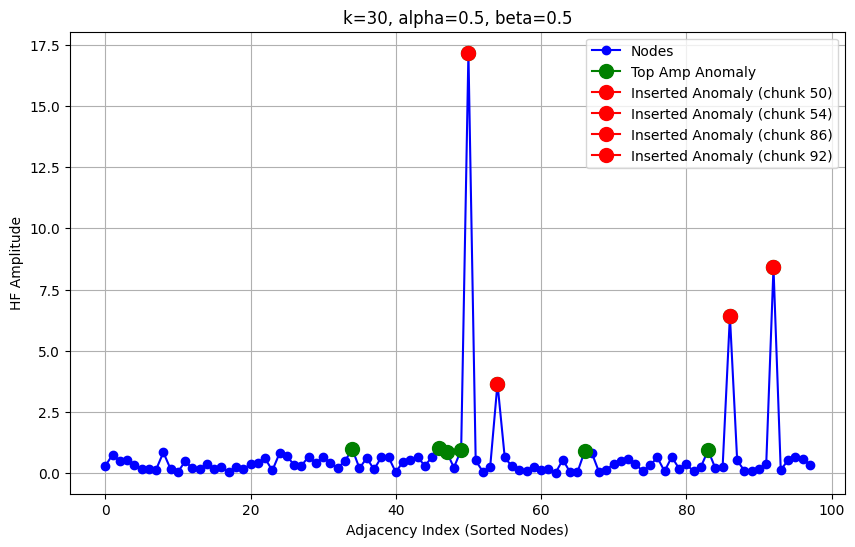

[INFO] Script complete.


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Example function to plot HF amplitudes in a line/marker style
def plot_amplitudes(k_val,
                    alpha,
                    beta,
                    sorted_nodes,
                    abs_hf_signal,
                    anomalies,
                    anomaly_positions):
    """
    Plots HF amplitude for each node in sorted_nodes, highlighting:
      - anomalies (top amplitude anomalies) in green
      - inserted anomalies in red

    Parameters:
      k_val, alpha, beta: used for including in the plot title
      sorted_nodes: list of chunk indices in ascending order
      abs_hf_signal: array of HF amplitude values (same length as sorted_nodes)
      anomalies: indices (in adjacency-index space) for the top amplitude anomalies
      anomaly_positions: list of chunk indices of inserted anomalies (original chunk IDs)
    """

    plt.figure(figsize=(10, 6))
    plt.title(f'k={k_val}, alpha={alpha}, beta={beta}')
    plt.xlabel('Adjacency Index (Sorted Nodes)')
    plt.ylabel('HF Amplitude')

    # x-values are simply the index in sorted_nodes
    x_vals = np.arange(len(sorted_nodes))

    # Plot all nodes as a line + markers in blue
    plt.plot(x_vals, abs_hf_signal,
             marker='o', color='blue', label='Nodes')

    # Highlight top amplitude anomalies (in green)
    for idx_ in anomalies:
        plt.plot(idx_, abs_hf_signal[idx_],
                 marker='o', color='green', markersize=10,
                 label='Top Amp Anomaly')

    # Highlight inserted anomalies (in red)
    for chunk_idx in anomaly_positions:
        # Find adjacency index for this chunk_idx
        adj_idx = np.where(np.array(sorted_nodes) == chunk_idx)[0]
        if len(adj_idx) > 0:
            plt.plot(adj_idx[0], abs_hf_signal[adj_idx[0]],
                     marker='o', color='red', markersize=10,
                     label=f'Inserted Anomaly (chunk {chunk_idx})')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------------
# The main script logic begins here
# ---------------------------------------------------------------------

# 1. Identify high-frequency eigenvectors
if HIGH_FREQ_METHOD == 'fraction':
    lambda_max = eigenvals[-1]
    freq_cut = HIGH_FREQ_CUTOFF_FRACTION * lambda_max
    high_freq_indices = np.where(eigenvals >= freq_cut)[0]
    print(f"[INFO] fraction method => eigenvals >= {freq_cut:.3f}")
elif HIGH_FREQ_METHOD == 'topk':
    topk = HIGH_FREQ_TOPK
    high_freq_indices = np.arange(len(eigenvals) - topk, len(eigenvals))
    print(f"[INFO] top-k method => largest {topk} eigenvalues.")
else:
    raise ValueError("HIGH_FREQ_METHOD must be 'fraction' or 'topk'")

# 2. Project the node signal onto the high-frequency eigenvectors
hf_eigenvecs = eigenvecs[:, high_freq_indices]
hf_coeffs = signal_hat[high_freq_indices]

hf_signal = hf_eigenvecs @ hf_coeffs
abs_hf_signal = np.abs(hf_signal)

# 3. Determine the threshold for top anomalies
thresh = np.percentile(abs_hf_signal, 100 - ANOMALY_TOP_PCT)
anomalies = np.where(abs_hf_signal >= thresh)[0]

# 4. Sort anomalies by amplitude descending, and print info
anomaly_info = []
for idx_ in anomalies:
    orig_node_id = sorted_nodes[idx_]
    amplitude = abs_hf_signal[idx_]
    snippet = chunks[orig_node_id][:250]  # Show the first 250 characters
    anomaly_info.append((orig_node_id, snippet, amplitude))

anomaly_info.sort(key=lambda x: x[2], reverse=True)

print(f"\n[INFO] High-frequency anomalies (top {ANOMALY_TOP_PCT}% amplitude), sorted descending:")
for node_id, snippet, amp in anomaly_info:
    print(f"Node {node_id}, HF amplitude={amp:.4f}")
    print(f"Snippet: {snippet}\n")

# 5. Identify which inserted anomalies appear in the top amplitude set
detected_inserted = []
for a_pos in anomaly_positions:
    adjacency_idx = np.where(np.array(sorted_nodes) == a_pos)[0]
    if len(adjacency_idx) > 0:
        if adjacency_idx[0] in anomalies:
            detected_inserted.append(a_pos)

if detected_inserted:
    print("[INFO] The following inserted anomalies are in the top amplitude set:")
    for d in detected_inserted:
        print(f" - Inserted anomaly at chunk {d} (adjacency index: {np.where(np.array(sorted_nodes) == d)[0][0]})")
else:
    print("[INFO] None of the inserted anomalies appear in the top amplitude set.")

# 6. Plot HF amplitude as a line plot with markers, highlighting anomalies
#    (instead of a bar chart).

# Example parameters for labeling the plot; change as needed
k_val = K
alpha = ALPHA
beta = BETA

plot_amplitudes(
    k_val,
    alpha,
    beta,
    sorted_nodes,
    abs_hf_signal,
    anomalies,         # adjacency indices of top amplitude
    anomaly_positions  # original chunk IDs of inserted anomalies
)

print("[INFO] Script complete.")


# Testing Script

In [ ]:
import numpy as np
import networkx as nx
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# ================================
#  1. DATA PREPROCESSING TESTS
# ================================

def test_chunk_creation(text, chunk_size=5, min_sentence_length=30):
    """
    Tests whether text is correctly split into chunks of the desired size,
    ensuring short sentences are filtered out properly.
    """
    all_sentences = nltk.sent_tokenize(text)
    filtered_sentences = [s for s in all_sentences if len(s.strip()) >= min_sentence_length]

    chunks = [" ".join(filtered_sentences[i:i + chunk_size]) for i in range(0, len(filtered_sentences), chunk_size)]
    print(f"[TEST] Chunk creation passed - {len(chunks)} chunks created.")
    return chunks

def test_anomaly_insertion(chunks, anomaly_text):
    """
    Verifies that anomalies are inserted at the correct locations.
    """
    insert_pos = np.random.randint(0, len(chunks))
    chunks.insert(insert_pos, anomaly_text)

    if chunks[insert_pos] == anomaly_text:
        print(f"[TEST] Anomaly insertion passed - Inserted at position {insert_pos}")
        return insert_pos
    else:
        print("[ERROR] Anomaly insertion failed!")
        return None


# ================================
#  2. EMBEDDING GENERATION TESTS
# ================================

def test_bert_embedding_generation(text_chunks, model, tokenizer, device):
    """
    Ensures embeddings have the correct shape and are generated on the correct device.
    """
    batch_size = 8
    all_embeddings = []

    for start_idx in range(0, len(text_chunks), batch_size):
        batch = text_chunks[start_idx:start_idx + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeds)

    embeddings = np.vstack(all_embeddings)
    expected_dim = (len(text_chunks), 768)

    if embeddings.shape == expected_dim:
        print(f"[TEST] BERT embeddings passed - Shape {embeddings.shape} is correct.")
    else:
        print(f"[ERROR] BERT embeddings failed - Expected shape {expected_dim}, but got {embeddings.shape}")

    return embeddings


# ================================
#  3. GRAPH CONSTRUCTION TESTS
# ================================

def test_knn_graph_construction(embeddings, k=5):
    """
    Tests that the k-NN graph is correctly built and that each node connects to k neighbors.
    """
    similarity_matrix = cosine_similarity(embeddings)
    num_nodes = embeddings.shape[0]

    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)

    for i in range(num_nodes):
        top_k_indices = similarity_matrix[i].argsort()[-(k + 1):-1][::-1]
        for j in top_k_indices:
            G.add_edge(i, j, weight=similarity_matrix[i][j])

    # Verify each node has k edges (except edge cases)
    for node in G.nodes():
        num_edges = len(list(G.neighbors(node)))
        if num_edges > k:
            print(f"[ERROR] Node {node} has more than {k} edges!")
        elif num_edges < k and num_nodes > k:
            print(f"[WARNING] Node {node} has fewer than {k} edges! (Edge case scenario)")

    print(f"[TEST] k-NN graph construction passed - {num_nodes} nodes with {k} neighbors each.")
    return G


# ================================
#  4. SPECTRAL ANALYSIS TESTS
# ================================

def test_laplacian_matrix(G):
    """
    Ensures the Laplacian matrix has the correct dimensions.
    """
    num_nodes = len(G.nodes())
    degree_vals = np.array([G.degree[i] for i in G.nodes()], dtype=float)
    D = np.diag(degree_vals)
    sorted_nodes = sorted(G.nodes())
    A = nx.to_numpy_array(G, nodelist=sorted_nodes)

    L = D - A
    if L.shape == (num_nodes, num_nodes):
        print(f"[TEST] Laplacian matrix passed - Shape {L.shape} is correct.")
    else:
        print(f"[ERROR] Laplacian matrix failed - Expected ({num_nodes}, {num_nodes}), got {L.shape}")

    return L

def test_eigen_decomposition(L):
    """
    Verifies that eigenvalue decomposition works correctly.
    """
    eigenvals, eigenvecs = np.linalg.eigh(L)

    if eigenvals.shape[0] == L.shape[0] and eigenvecs.shape[0] == L.shape[0]:
        print(f"[TEST] Eigen decomposition passed - Shape {eigenvals.shape} is correct.")
    else:
        print("[ERROR] Eigen decomposition failed!")

    return eigenvals, eigenvecs


# ================================
#  5. INTEGRATION & WORKFLOW TESTS
# ================================

def test_end_to_end(text, anomaly_text, model, tokenizer, device, k=5):
    """
    Runs a minimal end-to-end test to validate the entire anomaly detection pipeline.
    """
    # Step 1: Preprocessing
    chunks = test_chunk_creation(text)
    anomaly_position = test_anomaly_insertion(chunks, anomaly_text)

    # Step 2: Embeddings
    embeddings = test_bert_embedding_generation(chunks, model, tokenizer, device)

    # Step 3: Graph Construction
    G = test_knn_graph_construction(embeddings, k)

    # Step 4: Laplacian Matrix & Eigen Analysis
    L = test_laplacian_matrix(G)
    eigenvals, eigenvecs = test_eigen_decomposition(L)

    # Step 5: Confirm anomaly detection
    print("[INFO] End-to-end test completed.")
    return True


# ================================
#  MAIN EXECUTION FOR TESTING
# ================================
if __name__ == "__main__":
    # Sample test text
    test_text = """
    This is a test dataset. It contains multiple sentences.
    Some sentences are normal, while others are anomalies.
    The goal is to detect them using spectral analysis.
    Machine learning methods such as transformers can help.
    """

    anomaly_text = "これは異常なテキストです。 It is an anomaly sentence."

    # Load BERT model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
    model = BertModel.from_pretrained("bert-base-multilingual-cased")
    model.to(device)
    model.eval()

    # Run the full test suite
    test_end_to_end(test_text, anomaly_text, model, tokenizer, device, k=5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[TEST] Chunk creation passed - 1 chunks created.
[TEST] Anomaly insertion passed - Inserted at position 0
[TEST] BERT embeddings passed - Shape (2, 768) is correct.
[TEST] k-NN graph construction passed - 2 nodes with 5 neighbors each.
[TEST] Laplacian matrix passed - Shape (2, 2) is correct.
[TEST] Eigen decomposition passed - Shape (2,) is correct.
[INFO] End-to-end test completed.
